#### Import

In [1]:
%matplotlib inline
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pip
from datetime import datetime

### Data  Extraction

#### Connection to database 

In [2]:
def DbConnect():
    conn = psycopg2.connect(host="localhost",database="FormulaOne",port=5432,user='postgres',password='root')
    return conn

In [3]:
circuit = pd.read_sql('select * from "CircuitDim"', con=DbConnect())
races= pd.read_sql('select * from "RaceDim"', con=DbConnect())
date= pd.read_sql('select * from "DateTimeDim"', con=DbConnect())
races= pd.read_sql('select * from "RaceDim"', con=DbConnect())
driver= pd.read_sql('select * from "DriverDim"', con=DbConnect())
constructor= pd.read_sql('select * from "ConstructorsDim"', con=DbConnect())
status= pd.read_sql('select * from "StatusDim"', con=DbConnect())
weather= pd.read_sql('select * from "WeatherDim"', con=DbConnect())
penalty= pd.read_sql('select * from "PenalityDim"', con=DbConnect())
result= pd.read_sql('select * from "RaceResultFact"', con=DbConnect())

C:\Anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are no

### Merging to a single DataFrame

##### Renaming Keys

In [4]:
races.rename(columns = {'datetime_fk':'dateId'}, inplace = True)
races.rename(columns = {'circuit_fk':'CircuitId'}, inplace = True)
result.rename(columns = {'race_fk':'raceId'}, inplace = True)
result.rename(columns = {'driver_fk':'DriverID'}, inplace = True)
result.rename(columns = {'constructor_fk':'constructorId'}, inplace = True)
result.rename(columns = {'status_fk':'statusId'}, inplace = True)
races.rename(columns = {'weather_fk':'weatherID'}, inplace = True)
result.rename(columns = {'penalty_fk':'penalityId'}, inplace = True)

In [5]:
df1 = pd.merge(races,date, on='dateId', how='inner')
Racedim = pd.merge(df1,circuit, on='CircuitId', how='inner')
df2 = pd.merge(result,Racedim, on='raceId', how='inner')
df3 = pd.merge(df2,driver, on='DriverID', how='inner')
df4 = pd.merge(df3,constructor, on='constructorId', how='inner')
df5 = pd.merge(df4,status, on='statusId', how='inner')
df6 = pd.merge(df5,weather, on='weatherID', how='inner')
df7 = pd.merge(df6,penalty, on='penalityId', how='inner')

### Data Anlysis

##### Preparing

In [6]:
Fact=df7

In [7]:
Fact.columns

Index(['raceId', 'DriverID', 'constructorId', 'statusId', 'points_x', 'rank',
       'laps', 'fastest_lapspeed', 'wins', 'laptime', 'pitstop', 'penalityId',
       'round', 'name_x', 'CircuitId', 'dateId_x', 'weatherID', 'date', 'day',
       'month', 'year', 'time', 'circuitRef', 'name_y', 'location', 'latitude',
       'longitude', 'Altitude', 'country', 'img', 'DriverRef', 'Number',
       'Code', 'ForeName', 'SurName', 'Dob', 'Nationality', 'points_y', 'car',
       'constructorRef', 'constructorName', 'constructorNationality', 'status',
       'weather', 'points', 'reason', 'raceName', 'driverCode', 'dateId_y'],
      dtype='object')

##### Deleting data before 2014

Due to the lack of data accuracy before 2014 and the constant changes occurring on the formula one rules we saw best to only consider data from 2014 and above.

In [8]:
Fact=Fact.drop(Fact[(Fact["year"] <=2014)].index)

##### Cleaning

In [9]:
Fact["nameDriver"]=Fact["ForeName"]+" "+Fact["SurName"]
Fact["nameDriver"]
Fact['Dob']=pd.to_datetime(Fact['Dob'])
date=datetime.today()-Fact['Dob']
Fact['age']=round(date.dt.days/365)

Calculating the drivers' age is more significant that having a birth date as it provides us a mesurable value.

In [10]:
Fact.drop(columns=['raceId',
                   'DriverID',
                   'constructorId',
                   'CircuitId',
                   'statusId',
                   'statusId',
                   'weatherID',
                   'penalityId',
                   'dateId_x',
                   'dateId_y',
                   'constructorRef',
                   'DriverRef',
                   'circuitRef',
                   'ForeName',
                   'SurName',
                   'Dob',
                   'Number',
                   'Code',
                   'day',
                   'month',
                   'raceName',
                   'driverCode'],axis=1,inplace=True)

In [11]:
Fact.rename(columns = {'name_x':'nameGP','name_y':'nameCircuit','points':'penalityPoints'}, inplace = True)

In [12]:
Fact.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2009 entries, 70 to 2901
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   points_x                2009 non-null   float64
 1   rank                    2009 non-null   int64  
 2   laps                    2009 non-null   int64  
 3   fastest_lapspeed        2000 non-null   float64
 4   wins                    2009 non-null   int64  
 5   laptime                 2009 non-null   object 
 6   pitstop                 2009 non-null   object 
 7   round                   2009 non-null   int64  
 8   nameGP                  2009 non-null   object 
 9   date                    2009 non-null   object 
 10  year                    2009 non-null   int64  
 11  time                    2009 non-null   object 
 12  nameCircuit             2009 non-null   object 
 13  location                2009 non-null   object 
 14  latitude                2009 non-null  

In [13]:
Fact.shape

(2009, 30)

In [14]:
Fact.head()

,points_x,rank,laps,fastest_lapspeed,wins,laptime,pitstop,round,nameGP,date,...,points_y,car,constructorName,constructorNationality,status,weather,penalityPoints,reason,nameDriver,age
70,15.0,3,58,208.740,0,01:32:28.590000,00:00:22.694000,1,Australian Grand Prix,2015-03-15,...,43.0,Aston Martin Mercedes,Ferrari,Italian,Finished,None,2.0,Collision with Esteban Ocon,Sebastian Vettel,35.0
71,25.0,1,56,193.501,1,01:41:05.793000,00:00:49.088000,2,Malaysian Grand Prix,2015-03-29,...,43.0,Aston Martin Mercedes,Ferrari,Italian,Finished,None,2.0,Collision with Esteban Ocon,Sebastian Vettel,35.0
72,15.0,3,56,190.487,0,01:39:44.996000,00:00:44.932000,3,Chinese Grand Prix,2015-04-12,...,43.0,Aston Martin Mercedes,Ferrari,Italian,Finished,None,2.0,Collision with Esteban Ocon,Sebastian Vettel,35.0
73,10.0,5,57,201.639,0,01:35:49.798000,00:01:22.879000,4,Bahrain Grand Prix,2015-04-19,...,43.0,Aston Martin Mercedes,Ferrari,Italian,Finished,None,2.0,Collision with Esteban Ocon,Sebastian Vettel,35.0
74,15.0,3,66,184.687,0,01:41:57.897000,00:00:43.598000,5,Spanish Grand Prix,2015-05-10,...,43.0,Aston Martin Mercedes,Ferrari,Italian,Finished,None,2.0,Collision with Esteban Ocon,Sebastian Vettel,35.0


In [15]:
Fact.tail()

,points_x,rank,laps,fastest_lapspeed,wins,laptime,pitstop,round,nameGP,date,...,points_y,car,constructorName,constructorNationality,status,weather,penalityPoints,reason,nameDriver,age
2897,0.0,16,77,159.484,0,01:43:46.428000,00:01:22.543000,6,Monaco Grand Prix,2018-05-27,...,1.0,Williams Mercedes,Williams,British,+1 Lap,Cloudy,2.0,Causing a collision,Sergey Sirotkin,27.0
2898,0.0,12,43,231.085,0,01:23:54.334000,00:00:42.130000,13,Belgian Grand Prix,2018-08-26,...,1.0,Williams Mercedes,Williams,British,+1 Lap,Cloudy,2.0,Causing a collision,Sergey Sirotkin,27.0
2899,1.0,10,52,246.568,0,01:17:00.656000,00:00:25.245000,14,Italian Grand Prix,2018-09-02,...,1.0,Williams Mercedes,Williams,British,+1 Lap,Cloudy,2.0,Causing a collision,Sergey Sirotkin,27.0
2900,0.0,16,69,208.887,0,01:27:25.980000,00:00:23.273000,20,Brazilian Grand Prix,2018-11-11,...,1.0,Williams Mercedes,Williams,British,+2 Laps,Cloudy,2.0,Causing a collision,Sergey Sirotkin,27.0
2901,0.0,19,51,208.609,0,01:09:59.300000,00:00:45.884000,11,German Grand Prix,2018-07-22,...,1.0,Williams Mercedes,Williams,British,Engine,Unstable,2.0,Causing a collision,Sergey Sirotkin,27.0


#####  Checking for null Data

In [16]:
Fact.isnull().sum()*100/len(Fact)

points_x                   0.000000
rank                       0.000000
laps                       0.000000
fastest_lapspeed           0.447984
wins                       0.000000
laptime                    0.000000
pitstop                    0.000000
round                      0.000000
nameGP                     0.000000
date                       0.000000
year                       0.000000
time                       0.000000
nameCircuit                0.000000
location                   0.000000
latitude                   0.000000
longitude                  0.000000
Altitude                   0.000000
country                    0.000000
img                        0.000000
Nationality                0.000000
points_y                   0.000000
car                        0.000000
constructorName            0.000000
constructorNationality     0.000000
status                     0.000000
weather                   39.372822
penalityPoints             0.000000
reason                     0

In [17]:
Fact['weather'].fillna(Fact['weather'].mode().iloc[0], inplace=True)
Fact['fastest_lapspeed'].fillna(Fact['fastest_lapspeed'].median(), inplace=True)
Fact['laptime_sec']=0
for i in range(0,len(Fact)):
    t=Fact['laptime'].iat[i]
    if t is None:
        Fact['laptime_sec'].iat[i] = int(0)
    else:
        Fact['laptime_sec'].iat[i] = int(t.hour*3600000000+t.minute*60000000+t.second*1000000+t.microsecond)

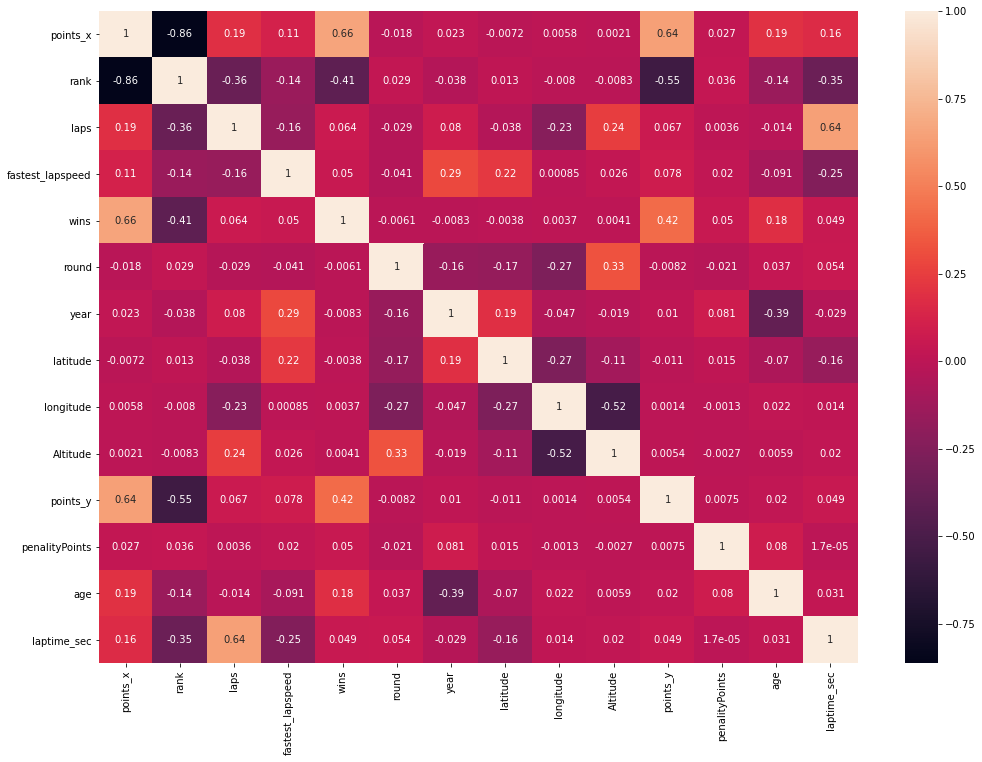

In [18]:
# heatmap

plt.figure(figsize=(17,12))
sns.heatmap(Fact.corr(),annot=True)
plt.show()

## Algorithms

driver's performance in RS

Relevent data

In [19]:
DriverPRS=Fact.drop(columns=[
                   'date',
                   'img',
                   'time',
                   'nameCircuit',
                    'location',
                    'country',
                    'Nationality',
                    'constructorName',
                    'constructorNationality',
                    'reason',
                    'laptime',
'longitude',
'penalityPoints',
'status',
'Altitude',
'nameGP',
'pitstop',
'points_x',
'wins',
'round',
'year',
'points_y',
'car',
'weather',
'nameDriver','latitude'])


In [20]:
DriverPRS.head()

,rank,laps,fastest_lapspeed,age,laptime_sec
70,3,58,208.740,35.0,5548590000
71,1,56,193.501,35.0,6065793000
72,3,56,190.487,35.0,5984996000
73,5,57,201.639,35.0,5749798000
74,3,66,184.687,35.0,6117897000


##### Variables encoding

from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
DriverPRS["nameDriver"] = lb_make.fit_transform(DriverPRS["nameDriver"])
DriverPRS["car"] = lb_make.fit_transform(DriverPRS["car"])
DriverPRS["weather"] = lb_make.fit_transform(DriverPRS["weather"])
DriverPRS

##### Correlation test

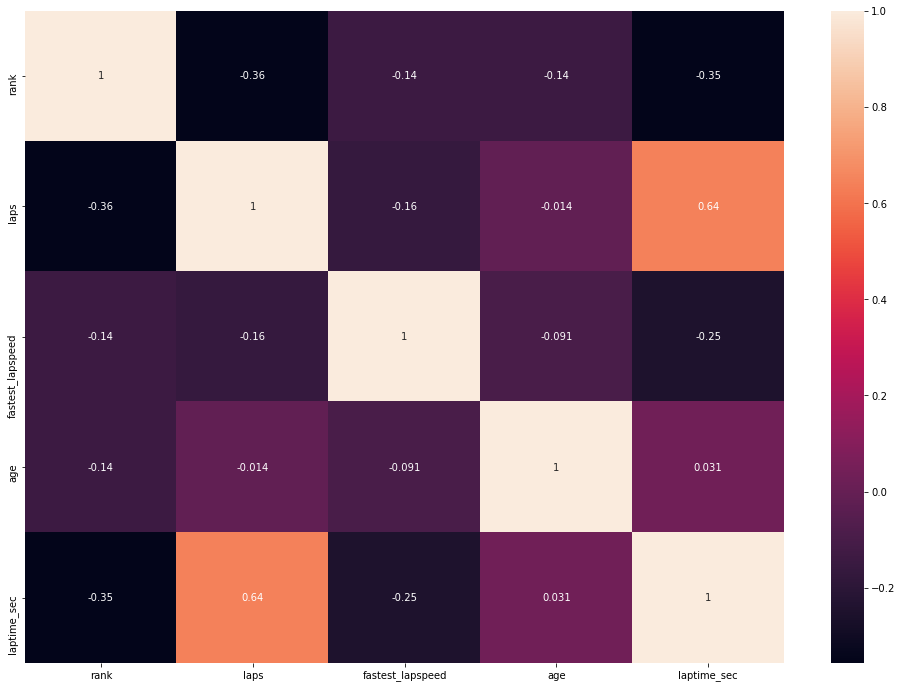

In [21]:
# heatmap

plt.figure(figsize=(17,12))
sns.heatmap(DriverPRS.corr(),annot=True)
plt.show()

In [22]:
DriverPRS['position_perf']=0
for i in range(0,len(DriverPRS)):
    pos=DriverPRS['rank'].iat[i]
    if pos>0 and pos<6:
         DriverPRS['position_perf'].iat[i] = int(1)
    elif pos>5 and pos<11:
         DriverPRS['position_perf'].iat[i] = int(2)
    elif pos>10 and pos<16:
         DriverPRS['position_perf'].iat[i] = int(3)
    else:
         DriverPRS['position_perf'].iat[i] = int(4)

In [23]:
DriverPRS

,rank,laps,fastest_lapspeed,age,laptime_sec,position_perf
70,3,58,208.740,35.0,5548590000,1
71,1,56,193.501,35.0,6065793000,1
72,3,56,190.487,35.0,5984996000,1
73,5,57,201.639,35.0,5749798000,1
74,3,66,184.687,35.0,6117897000,1
...,...,...,...,...,...,...
2897,16,77,159.484,27.0,6226428000,4
2898,12,43,231.085,27.0,5034334000,3
2899,10,52,246.568,27.0,4620656000,2
2900,16,69,208.887,27.0,5245980000,4


In [24]:
#separate the other attributes from the predicting attribute
X = DriverPRS.drop(columns=['position_perf','rank'])
#separte the predicting attribute into Y for model training
y = DriverPRS['position_perf']

In [25]:
# importing train_test_split from sklearn
from sklearn.model_selection import train_test_split
# splitting the data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=5)

In [26]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, y_train);

In [27]:
print('training accuracy = ' + str(dt.score(X_train, y_train)))
print('test accuracy = '+ str(dt.score(X_test, y_test)))

training accuracy = 1.0
test accuracy = 0.5157545605306799


In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
val_score=[]
K=np.arange(1,50)
for i in K:
    score=cross_val_score(KNeighborsClassifier(n_neighbors=i),X_train,y_train,cv=5)
    val_score.append(score.mean())

val_score

[0.3698518462431539,
 0.3684005956437243,
 0.37197445798945006,
 0.3826329471744782,
 0.3783650084551122,
 0.36769894752782617,
 0.37127785770172383,
 0.3698594179854117,
 0.3663082708664597,
 0.37054592261679414,
 0.359173165745438,
 0.35633628631281394,
 0.3606067489462659,
 0.36415537215113203,
 0.34851215264632385,
 0.355616970798314,
 0.35844627848868027,
 0.3619949016935463,
 0.35773453471643823,
 0.3669771080992403,
 0.3669720602710684,
 0.3677014714419121,
 0.3783700562832841,
 0.3712601903031221,
 0.3712576663890361,
 0.37267863001943413,
 0.3669872037555842,
 0.36557633578153,
 0.3669947754978421,
 0.3620125690921481,
 0.3684132152141541,
 0.35917064183135206,
 0.3627167411221322,
 0.3627192650362182,
 0.36272178895030416,
 0.360594129375836,
 0.35774967820095405,
 0.3613033492339921,
 0.35988490951768004,
 0.3577471542868681,
 0.3563211428282981,
 0.3563261906564701,
 0.355616970798314,
 0.3570303626864542,
 0.36272683677847606,
 0.355616970798314,
 0.35987733777542213,
 0.3

In [29]:
print(len(val_score))

49


In [34]:
# chargement du modèle KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier 
# Entrainer le modèle avec la méthode fit
KNN=KNeighborsClassifier(n_neighbors=2) 
KNN.fit(X_train,y_train)



KNeighborsClassifier(n_neighbors=2)

In [35]:
# Calculate models' score
y_pred=KNN.predict(X_test)
print(KNN.score(X_train,y_train))
print(KNN.score(X_test, y_test))


0.689900426742532
0.3946932006633499


In [47]:
test={'laps':['77'],'fastest_lapspeed':['160'],'age':['27'],'laptime_sec':['64006428000']}
df=pd.DataFrame(test)
pred = KNN.predict(df)
print(pred)

[3]


In [50]:
import pickle
pickle.dump(KNN, open('Knn.pkl','wb'))

# Loading model to compare the results
model = pickle.load(open('Knn.pkl','rb'))